In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [51]:
data_raw = pd.read_csv('Student Dropout Data.csv', header=None)

header_row = data_raw.iloc[0, 0]  
column_names = header_row.split(';') 

data = pd.read_csv('Student Dropout Data.csv', sep=';', skiprows=1, names=column_names)
data

,Marital status,Application mode,Application order,Course,"""Daytime/evening attendance\t""",Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


C:\Users\I-An Chang\AppData\Local\Temp\ipykernel_3908\3927710388.py:6: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.countplot(


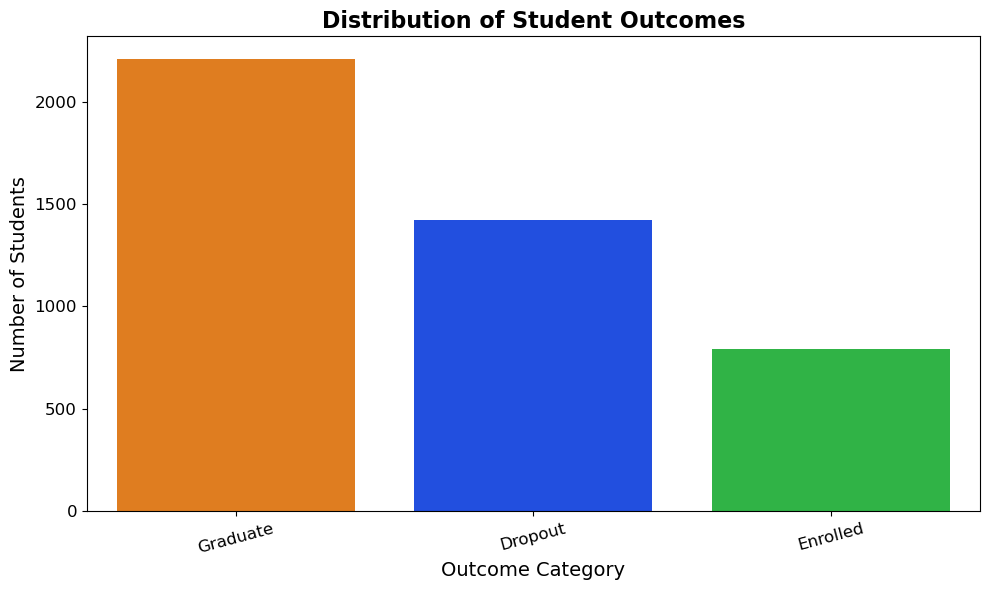

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=data, 
    x='Target', 
    hue='Target', 
    palette=sns.color_palette("bright"),
    order=data['Target'].value_counts().index
)

# Titles and labels
plt.title('Distribution of Student Outcomes', fontsize=16, fontweight='bold')
plt.xlabel('Outcome Category', fontsize=14)
plt.ylabel('Number of Students', fontsize=14)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [53]:
label_encoder = LabelEncoder()
data['Target'] = label_encoder.fit_transform(data['Target'])

# map classes to integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print(label_mapping)

{'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}


In [54]:
# train-test split
X = data.drop(columns=['Target'])
y = data['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

### XGBoost

In [7]:
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=1234)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
report_xgb = classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_, output_dict = True)
report_xgb

{'Dropout': {'precision': 0.78515625,
  'recall': 0.7760617760617761,
  'f1-score': 0.7805825242718447,
  'support': 259.0},
 'Enrolled': {'precision': 0.5178571428571429,
  'recall': 0.36024844720496896,
  'f1-score': 0.4249084249084249,
  'support': 161.0},
 'Graduate': {'precision': 0.8259187620889749,
  'recall': 0.9182795698924732,
  'f1-score': 0.869653767820774,
  'support': 465.0},
 'accuracy': 0.7751412429378531,
 'macro avg': {'precision': 0.7096440516487058,
  'recall': 0.6848632643864061,
  'f1-score': 0.6917149056670145,
  'support': 885.0},
 'weighted avg': {'precision': 0.7579465458998569,
  'recall': 0.7751412429378531,
  'f1-score': 0.7626781155178803,
  'support': 885.0}}

In [55]:
# Define parameter distributions
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 5),
    'reg_lambda': uniform(0, 5)
}

# Randomized search setup
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,          # Try 50 random combinations
    scoring='accuracy', # Or f1_macro', 'roc_auc_ovr' depending on your target
    cv=5,              
    verbose=2,
    n_jobs=-1,          
    random_state=1234
)

# Fit to training data
random_search.fit(X_train, y_train)
print("Best parameters found:", random_search.best_params_)
best_xgb_model = random_search.best_estimator_

# Evaluate
y_pred_best_xgb = best_xgb_model.predict(X_test)
report_best_xgb = classification_report(y_test, y_pred_best_xgb, target_names=label_encoder.classes_, output_dict=True)
report_best_xgb

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'colsample_bytree': 0.7515415826539049, 'gamma': 0.0688422479534112, 'learning_rate': 0.2418479864837122, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 843, 'reg_alpha': 3.6914338400735023, 'reg_lambda': 4.4461306585140985, 'subsample': 0.9935696511299312}


{'Dropout': {'precision': 0.8,
  'recall': 0.7722007722007722,
  'f1-score': 0.7858546168958742,
  'support': 259.0},
 'Enrolled': {'precision': 0.5135135135135135,
  'recall': 0.35403726708074534,
  'f1-score': 0.41911764705882354,
  'support': 161.0},
 'Graduate': {'precision': 0.8206106870229007,
  'recall': 0.9247311827956989,
  'f1-score': 0.8695652173913043,
  'support': 465.0},
 'accuracy': 0.7762711864406779,
 'macro avg': {'precision': 0.711374733512138,
  'recall': 0.6836564073590722,
  'f1-score': 0.6915124937820006,
  'support': 885.0},
 'weighted avg': {'precision': 0.7587114634365248,
  'recall': 0.7762711864406779,
  'f1-score': 0.763121031683004,
  'support': 885.0}}

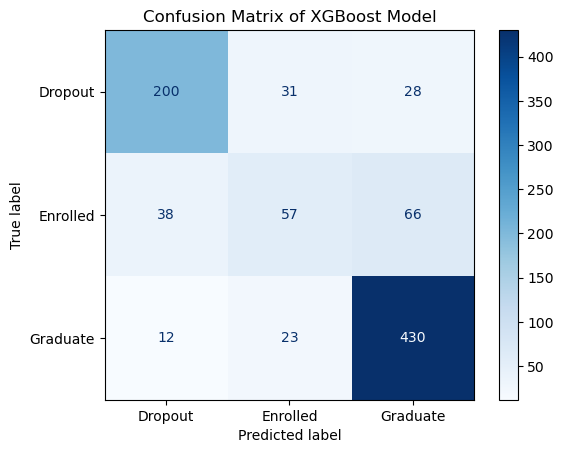

In [56]:
cm_xgb_best = confusion_matrix(y_test, y_pred_best_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_best, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix of XGBoost Model')
plt.show()

### Catboost

In [14]:
catboost_model = CatBoostClassifier(verbose=0, random_state=1234)
catboost_model.fit(X_train, y_train)

y_pred_cat = catboost_model.predict(X_test)
report_cat = classification_report(y_test, y_pred_cat, target_names=label_encoder.classes_, output_dict=True)
report_cat

              precision    recall  f1-score   support

     Dropout       0.80      0.76      0.78       259
    Enrolled       0.51      0.35      0.42       161
    Graduate       0.82      0.93      0.87       465

    accuracy                           0.78       885
   macro avg       0.71      0.68      0.69       885
weighted avg       0.76      0.78      0.76       885



{'Dropout': {'precision': 0.7951807228915663,
  'recall': 0.7644787644787645,
  'f1-score': 0.7795275590551181,
  'support': 259.0},
 'Enrolled': {'precision': 0.5089285714285714,
  'recall': 0.35403726708074534,
  'f1-score': 0.4175824175824176,
  'support': 161.0},
 'Graduate': {'precision': 0.8244274809160306,
  'recall': 0.9290322580645162,
  'f1-score': 0.8736097067745198,
  'support': 465.0},
 'accuracy': 0.7762711864406779,
 'macro avg': {'precision': 0.709512258412056,
  'recall': 0.682516096541342,
  'f1-score': 0.6902398944706851,
  'support': 885.0},
 'weighted avg': {'precision': 0.7584724133953332,
  'recall': 0.7762711864406779,
  'f1-score': 0.7631151646058718,
  'support': 885.0}}

In [15]:
# Define parameter space
param_dist = {
    'iterations': randint(100, 1000),
    'depth': randint(4, 10),
    'learning_rate': uniform(0.01, 0.3),
    'l2_leaf_reg': uniform(1, 9),
    'bagging_temperature': uniform(0, 1),
    'border_count': randint(32, 255)
}

# Randomized search setup
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=50,        
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=1234
)

# Fit to the training data
random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)
best_cat_model = random_search.best_estimator_

# Evaluate
y_pred_best_cat = best_cat_model.predict(X_test)
print(classification_report(y_test, y_pred_best_cat, target_names=label_encoder.classes_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'bagging_temperature': 0.03533422113382989, 'border_count': 164, 'depth': 7, 'iterations': 490, 'l2_leaf_reg': 5.031117055737298, 'learning_rate': 0.24479077305647257}
              precision    recall  f1-score   support

     Dropout       0.81      0.76      0.78       259
    Enrolled       0.51      0.39      0.44       161
    Graduate       0.82      0.92      0.87       465

    accuracy                           0.78       885
   macro avg       0.71      0.69      0.70       885
weighted avg       0.76      0.78      0.76       885



In [ ]:
cm_cat_best = confusion_matrix(y_test, y_pred_best_cat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cat_best, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix of CatBoost Model')
plt.show()

### Dropout vs All

In [34]:
data = pd.read_csv('Student Dropout Data.csv', sep=';', skiprows=1, names=column_names)
data_grouped = data.copy() 
data_grouped['Target'] = data_grouped['Target'].replace({
    'Graduate': 'No Dropout',
    'Enrolled': 'No Dropout'
})
data_grouped['Target'].unique()

array(['Dropout', 'No Dropout'], dtype=object)

In [29]:
label_encoder = LabelEncoder()
data_grouped['Target'] = label_encoder.fit_transform(data_grouped['Target'])

# map classes to integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print(label_mapping)

{'Dropout': 0, 'No Dropout': 1}


In [30]:
# train-test split
X = data_grouped.drop(columns=['Target'])
y = data_grouped['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [31]:
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=1234)
xgb_model.fit(X_train, y_train)

# Evaluate
y_pred_xgb = xgb_model.predict(X_test)
report_xgb = classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_, output_dict = True)
report_xgb

{'Dropout': {'precision': 0.8533333333333334,
  'recall': 0.7413127413127413,
  'f1-score': 0.7933884297520661,
  'support': 259.0},
 'No Dropout': {'precision': 0.8984848484848484,
  'recall': 0.9472843450479234,
  'f1-score': 0.9222395023328149,
  'support': 626.0},
 'accuracy': 0.8870056497175142,
 'macro avg': {'precision': 0.875909090909091,
  'recall': 0.8442985431803323,
  'f1-score': 0.8578139660424405,
  'support': 885.0},
 'weighted avg': {'precision': 0.8852710152371168,
  'recall': 0.8870056497175142,
  'f1-score': 0.8845305443685054,
  'support': 885.0}}

In [35]:
# Define parameter distributions
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 5),
    'reg_lambda': uniform(0, 5)
}

# Randomized search setup
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,          
    scoring='accuracy', 
    cv=5,              
    verbose=2,
    n_jobs=-1,          
    random_state=1234
)

# Fit to training data
random_search.fit(X_train, y_train)
print("Best parameters found:", random_search.best_params_)
best_xgb_model = random_search.best_estimator_

# Evaluate
y_pred_best_xgb = best_xgb_model.predict(X_test)
report_best_xgb = classification_report(y_test, y_pred_best_xgb, target_names=label_encoder.classes_, output_dict=True)
report_best_xgb

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'colsample_bytree': 0.5068556917270466, 'gamma': 2.0667479695982887, 'learning_rate': 0.07595714867473226, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 230, 'reg_alpha': 3.506776896183465, 'reg_lambda': 3.1138829330159954, 'subsample': 0.746841322873556}


{'Dropout': {'precision': 0.8678414096916299,
  'recall': 0.7606177606177607,
  'f1-score': 0.8106995884773662,
  'support': 259.0},
 'No Dropout': {'precision': 0.9057750759878419,
  'recall': 0.952076677316294,
  'f1-score': 0.9283489096573209,
  'support': 626.0},
 'accuracy': 0.896045197740113,
 'macro avg': {'precision': 0.8868082428397359,
  'recall': 0.8563472189670274,
  'f1-score': 0.8695242490673436,
  'support': 885.0},
 'weighted avg': {'precision': 0.8946735849474815,
  'recall': 0.896045197740113,
  'f1-score': 0.8939182043628483,
  'support': 885.0}}

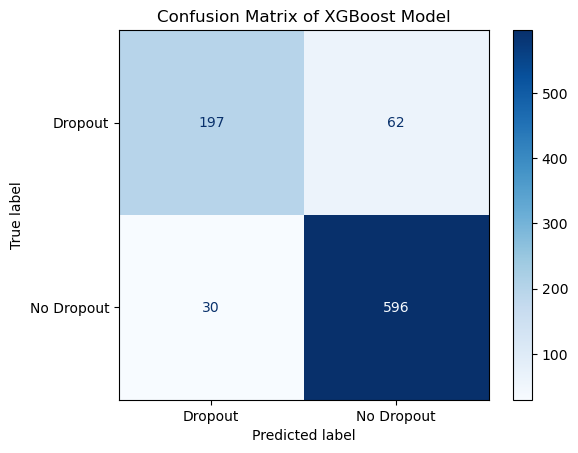

In [50]:
cm_xgb_best = confusion_matrix(y_test, y_pred_best_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_best, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix of XGBoost Model')
plt.show()

In [40]:
catboost_model = CatBoostClassifier(verbose=0, random_state=1234)
catboost_model.fit(X_train, y_train)

y_pred_cat = catboost_model.predict(X_test)
report_cat = classification_report(y_test, y_pred_cat, target_names=label_encoder.classes_, output_dict=True)
report_cat

array([[194,  65],
       [ 29, 597]], dtype=int64)

In [47]:
# Define parameter distributions
param_dist = {
    'iterations': randint(100, 1000),
    'depth': randint(4, 10),
    'learning_rate': uniform(0.01, 0.3),
    'l2_leaf_reg': uniform(1, 9),
    'bagging_temperature': uniform(0, 1),
    'border_count': randint(32, 255)
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=50,        
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=1234
)

# Fit to the training data
random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)
best_cat_model = random_search.best_estimator_

# Evaluate
y_pred_best_cat = best_cat_model.predict(X_test)
report_cat_best = classification_report(y_test, y_pred_best_cat, target_names=label_encoder.classes_, output_dict=True)
report_cat_best

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'bagging_temperature': 0.6575517771578194, 'border_count': 196, 'depth': 5, 'iterations': 395, 'l2_leaf_reg': 6.632947760182144, 'learning_rate': 0.07610868242509339}


{'Dropout': {'precision': 0.8616071428571429,
  'recall': 0.7451737451737451,
  'f1-score': 0.7991718426501035,
  'support': 259.0},
 'No Dropout': {'precision': 0.9001512859304085,
  'recall': 0.950479233226837,
  'f1-score': 0.9246309246309247,
  'support': 626.0},
 'accuracy': 0.8903954802259887,
 'macro avg': {'precision': 0.8808792143937757,
  'recall': 0.8478264892002911,
  'f1-score': 0.861901383640514,
  'support': 885.0},
 'weighted avg': {'precision': 0.8888711355846731,
  'recall': 0.8903954802259887,
  'f1-score': 0.8879146509212832,
  'support': 885.0}}

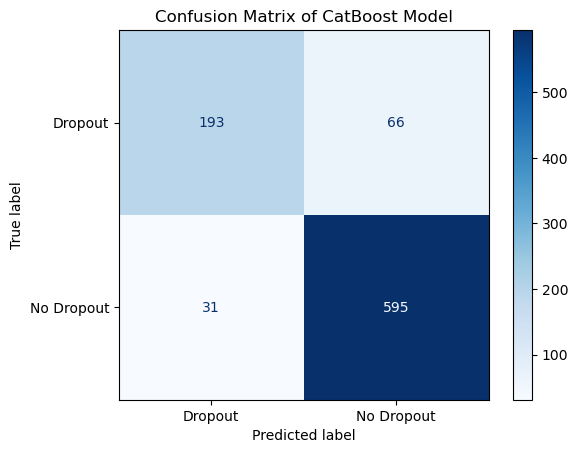

In [49]:
cm_cat_best = confusion_matrix(y_test, y_pred_best_cat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cat_best, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix of CatBoost Model')
plt.show()